Adjusting @rhtsingh's amazing notebook and data-processing pipeline (https://www.kaggle.com/rhtsingh/chaii-qa-5-fold-xlmroberta-torch-fit/notebook)

This notebook experiments with Bias-term Fine-tuning https://arxiv.org/abs/2106.10199)

The authors find that fine-tuning bias-terms only appears to be a really efficient way to train and still achieve close to (**or better**) performance than fine-tuning the whole network.

* While transformers can be unstable due to vanishing gradients - BitFit is also said to increase stability and allow training with larger LRs. (1e-4, 4e-4, 7e-4, 1e3)
* Training time is relatively faster (~ 32m, compared to ~50m+ fine-tuning the complete network)
* Bitfit is also found to 'dominate  over Full-FT in the smaller-data regime'

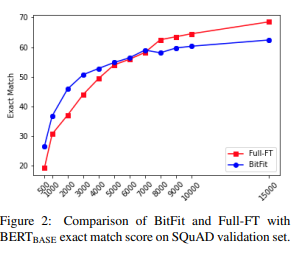

Thought this was interesting/might be useful for ensembling larger XLM-Roberta XXL models (https://arxiv.org/abs/2105.00572)

### Import Dependencies

In [ ]:
import gc
gc.enable()
import os
import math
import json
import time
import random
import multiprocessing
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from sklearn import model_selection
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.optim as optim
from torch.utils.data import (
    Dataset, DataLoader,
    SequentialSampler, RandomSampler
)
from fastai.losses import LabelSmoothingCrossEntropy, LabelSmoothingCrossEntropyFlat
from torch.utils.data.distributed import DistributedSampler

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    logging
)

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def optimal_num_of_loader_workers():
    num_cpus = multiprocessing.cpu_count()
    num_gpus = torch.cuda.device_count()
    optimal_value = min(num_cpus, num_gpus*4) if num_gpus else num_cpus - 1
    return optimal_value

### Training Config

In [ ]:
class Config:
    # model
    model_type = 'xlm_roberta'
    model_name_or_path = "deepset/xlm-roberta-large-squad2"
    config_name = "deepset/xlm-roberta-large-squad2"
    fp16 = False
    fp16_opt_level = "O1"
    gradient_accumulation_steps = 2

    # tokenizer
    tokenizer_name = "deepset/xlm-roberta-large-squad2"
    max_seq_length = 384
    doc_stride = 128

    # train
    epochs = 1
    train_batch_size = 4
    eval_batch_size = 8

    # optimizer
    optimizer_type = 'AdamW'
    bitfit_training = True # bitfit training should allow higher lrs/increase stability
    learning_rate = 4e-4   # common among many tasks in paper
    weight_decay = 1e-2
    epsilon = 1e-8
    max_grad_norm = 1.0

    # scheduler
    decay_name = 'linear-warmup'
    warmup_ratio = 0.1

    # logging
    logging_steps = 10

    # evaluate
    output_dir = 'output'
    seed = 111120

### Data Factory

In [ ]:
train = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/train.csv')
test = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/test.csv')
external_mlqa = pd.read_csv('../input/mlqa-hindi-processed/mlqa_hindi.csv')
external_xquad = pd.read_csv('../input/mlqa-hindi-processed/xquad.csv')
external_train = pd.concat([external_mlqa, external_xquad])

def create_folds(data, num_splits):
    data["kfold"] = -1
    kf = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=2021)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data['language'])):
        data.loc[v_, 'kfold'] = f
    return data

train = create_folds(train, num_splits=5)
external_train["kfold"] = -1
external_train['id'] = list(np.arange(1, len(external_train)+1))
train = pd.concat([train, external_train]).reset_index(drop=True)

def convert_answers(row):
    return {'answer_start': [row[0]], 'text': [row[1]]}

train['answers'] = train[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

### Preprocessing

In [ ]:
def prepare_train_features(args, example, tokenizer):
    example["question"] = example["question"].lstrip()
    tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=args.max_seq_length,
        stride=args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_example.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_example.pop("offset_mapping")

    features = []
    for i, offsets in enumerate(offset_mapping):
        feature = {}

        input_ids = tokenized_example["input_ids"][i]
        attention_mask = tokenized_example["attention_mask"][i]

        feature['input_ids'] = input_ids
        feature['attention_mask'] = attention_mask
        feature['offset_mapping'] = offsets

        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_example.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = example["answers"]

        if len(answers["answer_start"]) == 0:
            feature["start_position"] = cls_index
            feature["end_position"] = cls_index
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                feature["start_position"] = cls_index
                feature["end_position"] = cls_index
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                feature["start_position"] = token_start_index - 1
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                feature["end_position"] = token_end_index + 1

        features.append(feature)
    return features

prep_fn = partial(prepare_train_features, args = Config)

### Dataset Retriever

In [ ]:
class DatasetRetriever(Dataset):
    def __init__(self, features, mode='train'):
        super(DatasetRetriever, self).__init__()
        self.features = features
        self.mode = mode
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, item):   
        feature = self.features[item]
        if self.mode == 'train':
            return {
                'input_ids':torch.tensor(feature['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                'offset_mapping':torch.tensor(feature['offset_mapping'], dtype=torch.long),
                'start_position':torch.tensor(feature['start_position'], dtype=torch.long),
                'end_position':torch.tensor(feature['end_position'], dtype=torch.long)
            }
        else:
            return {
                'input_ids':torch.tensor(feature['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                'offset_mapping':feature['offset_mapping'],
                'sequence_ids':feature['sequence_ids'],
                'id':feature['example_id'],
                'context': feature['context'],
                'question': feature['question']
            }

### Model

In [ ]:
class Model(nn.Module):
    def __init__(self, modelname_or_path, config):
        super(Model, self).__init__()
        self.config = config
        self.xlm_roberta = AutoModel.from_pretrained(modelname_or_path, config=config)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self._init_weights(self.qa_outputs)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(
        self, 
        input_ids, 
        attention_mask=None
    ):
        outputs = self.xlm_roberta(
            input_ids,
            attention_mask=attention_mask,
        )

        sequence_output = outputs[0]
        pooled_output = outputs[1]
        
        qa_logits = self.qa_outputs(sequence_output)
        
        start_logits, end_logits = qa_logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
    
        return start_logits, end_logits

### Loss Function

In [ ]:
def loss_fn(preds, labels):
    start_preds, end_preds = preds
    start_labels, end_labels = labels
    
    start_loss = nn.CrossEntropyLoss(ignore_index=-1)(start_preds, start_labels)
    end_loss = nn.CrossEntropyLoss(ignore_index=-1)(end_preds, end_labels)
    total_loss = (start_loss + end_loss) / 2
    return total_loss

### Training Utils

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0
        self.min = 1e5

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        if val > self.max:
            self.max = val
        if val < self.min:
            self.min = val

In [ ]:
def make_model(args):
    config = AutoConfig.from_pretrained(args.config_name)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name)
    model = Model(args.model_name_or_path, config=config)
    return config, tokenizer, model

def make_optimizer(args, model):
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    if args.optimizer_type == "AdamW":
        optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=args.learning_rate,
            eps=args.epsilon,
            correct_bias=True
        )
        return optimizer

def make_scheduler(
    args, optimizer, 
    num_warmup_steps, 
    num_training_steps
):
    if args.decay_name == "cosine-warmup":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
    else:
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
    return scheduler    

def make_loader(
    args, data, 
    tokenizer, fold
):
    train_set, valid_set = data[data['kfold']!=fold], data[data['kfold']==fold]
    train_features = list(train_set.apply(lambda i: prep_fn(example=i, tokenizer=tokenizer),axis=1).explode())
    valid_features = list(valid_set.apply(lambda i: prep_fn(example=i, tokenizer=tokenizer),axis=1).explode())

    train_dataset = DatasetRetriever(train_features)
    valid_dataset = DatasetRetriever(valid_features)
    print(f"Num examples Train= {len(train_dataset)}, Num examples Valid={len(valid_dataset)}")
    
    train_sampler = RandomSampler(train_dataset)
    valid_sampler = SequentialSampler(valid_dataset)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.train_batch_size,
        sampler=train_sampler,
        num_workers=optimal_num_of_loader_workers(),
        pin_memory=True,
        drop_last=False 
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=args.eval_batch_size, 
        sampler=valid_sampler,
        num_workers=optimal_num_of_loader_workers(),
        pin_memory=True, 
        drop_last=False
    )

    return train_dataloader, valid_dataloader

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

### Trainer

In [ ]:
class Trainer:
    def __init__(
        self, model, tokenizer, 
        optimizer, scheduler
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train(
        self, args, 
        train_dataloader, 
        epoch, result_dict
    ):
        count = 0
        losses = AverageMeter()
        
        self.model.zero_grad()
        self.model.train()
        
        fix_all_seeds(args.seed)
        
        for batch_idx, batch_data in enumerate(train_dataloader):
            input_ids, attention_mask, targets_start, targets_end = \
                batch_data['input_ids'], batch_data['attention_mask'], \
                    batch_data['start_position'], batch_data['end_position']
            
            input_ids, attention_mask, targets_start, targets_end = \
                input_ids.cuda(), attention_mask.cuda(), targets_start.cuda(), targets_end.cuda()

            outputs_start, outputs_end = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            
            loss = loss_fn((outputs_start, outputs_end), (targets_start, targets_end))
            loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            count += input_ids.size(0)
            losses.update(loss.item(), input_ids.size(0))

            if batch_idx % args.gradient_accumulation_steps == 0 or batch_idx == len(train_dataloader) - 1:
                self.optimizer.step()
                self.scheduler.step()
                self.optimizer.zero_grad()

            if (batch_idx % args.logging_steps == 0) or (batch_idx+1)==len(train_dataloader):
                _s = str(len(str(len(train_dataloader.sampler))))
                ret = [
                    ('Epoch: {:0>2} [{: >' + _s + '}/{} ({: >3.0f}%)]').format(epoch, count, len(train_dataloader.sampler), 100 * count / len(train_dataloader.sampler)),
                    'Train Loss: {: >4.5f}'.format(losses.avg),
                ]
                print(', '.join(ret))

        result_dict['train_loss'].append(losses.avg)
        return result_dict

### Evaluator

In [ ]:
class Evaluator:
    def __init__(self, model):
        self.model = model
    def save(self, result, output_dir):
        with open(f'{output_dir}/result_dict.json', 'w') as f:
            f.write(json.dumps(result, sort_keys=True, indent=4, ensure_ascii=False))

    def evaluate(self, valid_dataloader, epoch, result_dict):
        losses = AverageMeter()
        for batch_idx, batch_data in enumerate(valid_dataloader):
            self.model = self.model.eval()
            input_ids, attention_mask, targets_start, targets_end = \
                batch_data['input_ids'], batch_data['attention_mask'], \
                    batch_data['start_position'], batch_data['end_position']
            
            input_ids, attention_mask, targets_start, targets_end = \
                input_ids.cuda(), attention_mask.cuda(), targets_start.cuda(), targets_end.cuda()
            
            with torch.no_grad():            
                outputs_start, outputs_end = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn((outputs_start, outputs_end), (targets_start, targets_end))
                losses.update(loss.item(), input_ids.size(0))
                
        print('----Validation Results Summary----')
        print('Epoch: [{}] Valid Loss: {: >4.5f}'.format(epoch, losses.avg))
        result_dict['val_loss'].append(losses.avg)        
        return result_dict

### Initialize Training

In [ ]:
def init_training(args, data, fold, bitfit = False):
    fix_all_seeds(args.seed)
    
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)
    
    # model
    model_config, tokenizer, model = make_model(args)
    if torch.cuda.device_count() >= 1:
        print('Model pushed to {} GPU(s), type {}.'.format(
            torch.cuda.device_count(), 
            torch.cuda.get_device_name(0))
        )
        model = model.cuda() 
    else:
        raise ValueError('CPU training is not supported')
        
    if args.bitfit_training:
        for n, param in model.xlm_roberta.named_parameters():
            if '.bias' in n:
                param.requires_grad = True
            else: 
                param.requires_grad = False
    
    # data loaders
    train_dataloader, valid_dataloader = make_loader(args, data, tokenizer, fold)

    # optimizer
    optimizer = make_optimizer(args, model)

    # scheduler
    num_training_steps = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps) * args.epochs
    if args.warmup_ratio > 0:
        num_warmup_steps = int(args.warmup_ratio * num_training_steps)
    else:
        num_warmup_steps = 0
    print(f"Total Training Steps: {num_training_steps}, Total Warmup Steps: {num_warmup_steps}")
    scheduler = make_scheduler(args, optimizer, num_warmup_steps, num_training_steps)

    # mixed precision training with NVIDIA Apex
    if args.fp16:
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)
    
    result_dict = {
        'epoch':[], 
        'train_loss': [], 
        'val_loss' : [], 
        'best_val_loss': np.inf
    }

    return (
        model, model_config, tokenizer, optimizer, scheduler, 
        train_dataloader, valid_dataloader, result_dict
    )

### Run

In [ ]:
def run(data, fold):
    args = Config()
    model, model_config, tokenizer, optimizer, scheduler, train_dataloader, \
        valid_dataloader, result_dict = init_training(args, data, fold, bitfit = True)
    
    trainer = Trainer(model, tokenizer, optimizer, scheduler)
    evaluator = Evaluator(model)

    train_time_list = []
    valid_time_list = []

    for epoch in range(args.epochs):
        result_dict['epoch'].append(epoch)

        # Train
        torch.cuda.synchronize()
        tic1 = time.time()
        result_dict = trainer.train(
            args, train_dataloader, 
            epoch, result_dict
        )
        torch.cuda.synchronize()
        tic2 = time.time() 
        train_time_list.append(tic2 - tic1)
        
        # Evaluate
        torch.cuda.synchronize()
        tic3 = time.time()
        result_dict = evaluator.evaluate(
            valid_dataloader, epoch, result_dict
        )
        torch.cuda.synchronize()
        tic4 = time.time() 
        valid_time_list.append(tic4 - tic3)
            
        output_dir = os.path.join(args.output_dir, f"checkpoint-fold-{fold}")
        if result_dict['val_loss'][-1] < result_dict['best_val_loss']:
            print("{} Epoch, Best epoch was updated! Valid Loss: {: >4.5f}".format(epoch, result_dict['val_loss'][-1]))
            result_dict["best_val_loss"] = result_dict['val_loss'][-1]        
            
            os.makedirs(output_dir, exist_ok=True)
            torch.save(model.state_dict(), f"{output_dir}/pytorch_model.bin")
            model_config.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)
            print(f"Saving model checkpoint to {output_dir}.")
            
        print()

    evaluator.save(result_dict, output_dir)
    
    print(f"Total Training Time: {np.sum(train_time_list)}secs, Average Training Time per Epoch: {np.mean(train_time_list)}secs.")
    print(f"Total Validation Time: {np.sum(valid_time_list)}secs, Average Validation Time per Epoch: {np.mean(valid_time_list)}secs.")
    
    torch.cuda.empty_cache()
    del trainer, evaluator
    del model, model_config, tokenizer
    del optimizer, scheduler
    del train_dataloader, valid_dataloader, result_dict
    gc.collect()

In [ ]:
for fold in range(1):
    print();print()
    print('-'*50)
    print(f'FOLD: {fold}')
    print('-'*50)
    run(train, fold)